# Import Packages

In [32]:
#import library
import pandas as pd
import numpy as np
import datetime as dt

# Data to Dataframe

In [33]:
df = pd.read_csv('online_retail_data.csv', header=0)
df.head()

,order_id,product_code,product_name,quantity,order_date,price,customer_id
0,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,12346.0
1,C493411,21539,RETRO SPOTS BUTTER DISH,-1,2010-01-04 09:43:00,4.25,14590.0
2,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.50,12346.0
3,493413,21724,PANDA AND BUNNIES STICKER SHEET,1,2010-01-04 09:54:00,0.85,NaN
4,493413,84578,ELEPHANT TOY WITH BLUE T-SHIRT,1,2010-01-04 09:54:00,3.75,NaN


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461773 entries, 0 to 461772
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      461773 non-null  object 
 1   product_code  461773 non-null  object 
 2   product_name  459055 non-null  object 
 3   quantity      461773 non-null  int64  
 4   order_date    461773 non-null  object 
 5   price         461773 non-null  float64
 6   customer_id   360853 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 24.7+ MB


# Data Cleansing

In [35]:
df_clean = df.copy()

#Set order_date to dt property and changes to year_month
df_clean['order_date'] = df_clean['order_date'].astype('datetime64[ns]')
df_clean['year_month'] = df_clean['order_date'].dt.to_period('M')

#Clean data without customer_id
df_clean = df_clean[~df_clean['customer_id'].isna()]

#Clean data without product_name and make it lower
df_clean = df_clean[~df_clean['product_name'].isna()]
df_clean['product_name'] = df_clean['product_name'].str.lower()

#Clean data with product_code and product_name test
df_clean = df_clean[~df_clean['product_code'].str.lower().str.contains('test')]
df_clean = df_clean[~df_clean['product_name'].str.lower().str.contains('test')]

#New order_status column from order_id. C: cancelled and D: delivered
df_clean['order_status'] = np.where(df_clean['order_id'].str[:1]=='C', 'cancelled', 'delivered')

#Change quantity values to all positive
df_clean['quantity'] = df_clean['quantity'].abs()

#Clean price column with negative values
df_clean = df_clean[df_clean['price']>0]

#New amount column from quantity * price
df_clean['amount'] = df_clean['quantity'] * df_clean['price']

#Change product_name from product_code which has several product_name
most_freq_product_name = df_clean.groupby(['product_code','product_name'], as_index=False).agg(order_cnt=('order_id','nunique')).sort_values(['product_code','order_cnt'], ascending=[True,False])
most_freq_product_name['rank'] = most_freq_product_name.groupby('product_code')['order_cnt'].rank(method='first', ascending=False)
most_freq_product_name = most_freq_product_name[most_freq_product_name['rank']==1].drop(columns=['order_cnt','rank'])
df_clean = df_clean.merge(most_freq_product_name.rename(columns={'product_name':'most_freq_product_name'}), how='left', on='product_code')
df_clean['product_name'] = df_clean['most_freq_product_name']
df_clean = df_clean.drop(columns='most_freq_product_name')

#Convert customer_id to str
df_clean['customer_id'] = df_clean['customer_id'].astype('str')

#Delete outlier
from scipy import stats
df_clean = df_clean[(np.abs(stats.zscore(df_clean[['quantity','amount']]))<3).all(axis=1)]
df_clean = df_clean.reset_index(drop=True)

df_clean

<ipython-input-35-422c593c8ef5>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['amount'] = df_clean['quantity'] * df_clean['price']


,order_id,product_code,product_name,quantity,order_date,price,customer_id,year_month,order_status,amount
0,C493411,21539,red retrospot butter dish,1,2010-01-04 09:43:00,4.25,14590.0,2010-01,cancelled,4.25
1,493414,21844,red retrospot mug,36,2010-01-04 10:28:00,2.55,14590.0,2010-01,delivered,91.80
2,493414,21533,retro spot large milk jug,12,2010-01-04 10:28:00,4.25,14590.0,2010-01,delivered,51.00
3,493414,37508,new england ceramic cake server,2,2010-01-04 10:28:00,2.55,14590.0,2010-01,delivered,5.10
4,493414,35001G,hand open shape gold,2,2010-01-04 10:28:00,4.25,14590.0,2010-01,delivered,8.50
...,...,...,...,...,...,...,...,...,...,...
358464,539988,84380,set of 3 butterfly cookie cutters,1,2010-12-23 16:06:00,1.25,18116.0,2010-12,delivered,1.25
358465,539988,84849D,hot baths soap holder,1,2010-12-23 16:06:00,1.69,18116.0,2010-12,delivered,1.69
358466,539988,84849B,fairy soap soap holder,1,2010-12-23 16:06:00,1.69,18116.0,2010-12,delivered,1.69
358467,539988,22854,cream sweetheart egg holder,2,2010-12-23 16:06:00,4.95,18116.0,2010-12,delivered,9.90


In [36]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358469 entries, 0 to 358468
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   order_id      358469 non-null  object        
 1   product_code  358469 non-null  object        
 2   product_name  358469 non-null  object        
 3   quantity      358469 non-null  int64         
 4   order_date    358469 non-null  datetime64[ns]
 5   price         358469 non-null  float64       
 6   customer_id   358469 non-null  object        
 7   year_month    358469 non-null  period[M]     
 8   order_status  358469 non-null  object        
 9   amount        358469 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5), period[M](1)
memory usage: 27.3+ MB


# Cohort Retention

## Aggregating transaction data by each total order customer in month

In [37]:
df_user_monthly = df_clean.groupby(['customer_id', 'year_month'], as_index=False).agg(order_count=('order_id','nunique'))
df_user_monthly

,customer_id,year_month,order_count
0,12346.0,2010-01,1
1,12346.0,2010-03,1
2,12346.0,2010-06,2
3,12346.0,2010-10,1
4,12608.0,2010-10,1
...,...,...,...
12039,18286.0,2010-06,1
12040,18286.0,2010-08,1
12041,18287.0,2010-05,1
12042,18287.0,2010-09,2


## Make new cohort column for every user

In [38]:
df_user_monthly['cohort'] = df_user_monthly.groupby('customer_id')['year_month'].transform('min')
df_user_monthly

,customer_id,year_month,order_count,cohort
0,12346.0,2010-01,1,2010-01
1,12346.0,2010-03,1,2010-01
2,12346.0,2010-06,2,2010-01
3,12346.0,2010-10,1,2010-01
4,12608.0,2010-10,1,2010-10
...,...,...,...,...
12039,18286.0,2010-06,1,2010-06
12040,18286.0,2010-08,1,2010-06
12041,18287.0,2010-05,1,2010-05
12042,18287.0,2010-09,2,2010-05


## Count the month transaction with user first transaction. +1 so the start month became 1 instead of 0

In [39]:
from operator import attrgetter

df_user_monthly['month_diff'] = (df_user_monthly['year_month'] - df_user_monthly['cohort']).apply(attrgetter('n')) + 1
df_user_monthly

,customer_id,year_month,order_count,cohort,month_diff
0,12346.0,2010-01,1,2010-01,1
1,12346.0,2010-03,1,2010-01,3
2,12346.0,2010-06,2,2010-01,6
3,12346.0,2010-10,1,2010-01,10
4,12608.0,2010-10,1,2010-10,1
...,...,...,...,...,...
12039,18286.0,2010-06,1,2010-06,1
12040,18286.0,2010-08,1,2010-06,3
12041,18287.0,2010-05,1,2010-05,1
12042,18287.0,2010-09,2,2010-05,5


## Pivot table, indexing the cohort with month_diff. The value is unique unique customer_id

In [40]:
df_cohort_pivot = df_user_monthly.pivot_table(index='cohort', columns='month_diff', values='customer_id', aggfunc=pd.Series.nunique)
df_cohort_pivot

month_diff,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,
2010-01,713.0,280.0,334.0,313.0,305.0,304.0,293.0,268.0,285.0,319.0,335.0,249.0
2010-02,461.0,154.0,128.0,161.0,152.0,121.0,119.0,159.0,153.0,166.0,100.0,NaN
2010-03,528.0,146.0,158.0,145.0,140.0,123.0,149.0,186.0,193.0,96.0,NaN,NaN
2010-04,326.0,82.0,75.0,63.0,69.0,79.0,98.0,101.0,50.0,NaN,NaN,NaN
2010-05,274.0,55.0,50.0,52.0,52.0,72.0,67.0,43.0,NaN,NaN,NaN,NaN
2010-06,266.0,53.0,56.0,60.0,65.0,85.0,39.0,NaN,NaN,NaN,NaN,NaN
2010-07,179.0,38.0,37.0,52.0,53.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,160.0,35.0,50.0,48.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09,227.0,64.0,60.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Count the number of user in each cohort (first_transaction only) and divide the value of pivot table to generate retention rate

In [41]:
cohort_size = df_cohort_pivot.iloc[:,0]
cohort_size

cohort
2010-01    713.0
2010-02    461.0
2010-03    528.0
2010-04    326.0
2010-05    274.0
2010-06    266.0
2010-07    179.0
2010-08    160.0
2010-09    227.0
2010-10    362.0
2010-11    327.0
2010-12     66.0
Freq: M, Name: 1, dtype: float64

In [42]:
df_retention_cohort = df_cohort_pivot.divide(cohort_size, axis=0)
df_retention_cohort

month_diff,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,
2010-01,1.0,0.392707,0.468443,0.438990,0.427770,0.426367,0.410940,0.375877,0.399719,0.447405,0.469846,0.349229
2010-02,1.0,0.334056,0.277657,0.349241,0.329718,0.262473,0.258134,0.344902,0.331887,0.360087,0.216920,NaN
2010-03,1.0,0.276515,0.299242,0.274621,0.265152,0.232955,0.282197,0.352273,0.365530,0.181818,NaN,NaN
2010-04,1.0,0.251534,0.230061,0.193252,0.211656,0.242331,0.300613,0.309816,0.153374,NaN,NaN,NaN
2010-05,1.0,0.200730,0.182482,0.189781,0.189781,0.262774,0.244526,0.156934,NaN,NaN,NaN,NaN
2010-06,1.0,0.199248,0.210526,0.225564,0.244361,0.319549,0.146617,NaN,NaN,NaN,NaN,NaN
2010-07,1.0,0.212291,0.206704,0.290503,0.296089,0.167598,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,1.0,0.218750,0.312500,0.300000,0.168750,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09,1.0,0.281938,0.264317,0.136564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Heatmap the result

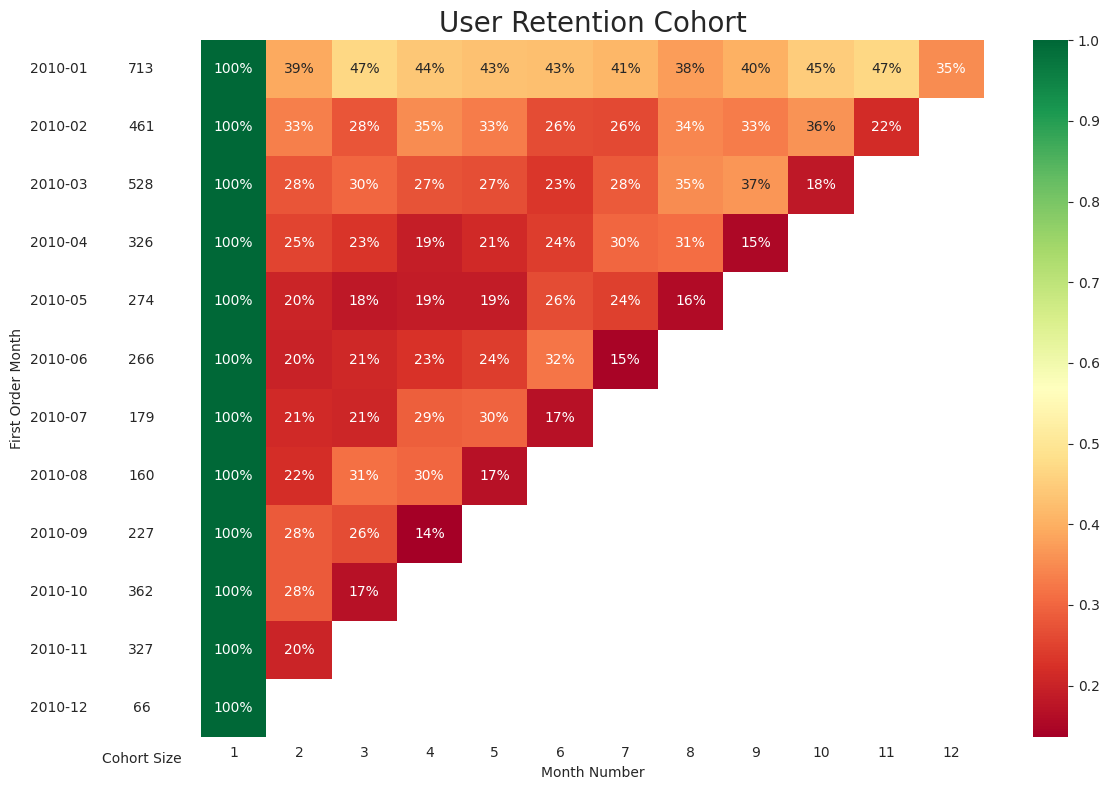

In [47]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12,8), sharey=True, gridspec_kw={'width_ratios':[1,11]})

    #User retention cohort
    sns.heatmap(df_retention_cohort, annot=True, fmt='.0%', cmap='RdYlGn', ax=ax[1])
    ax[1].set_title('User Retention Cohort', fontsize=20)
    ax[1].set(xlabel='Month Number', ylabel='')

    #cohort size
    df_cohort_size = pd.DataFrame(cohort_size)
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(df_cohort_size, annot=True, cbar=False, fmt='g' ,cmap=white_cmap, ax=ax[0])
    ax[0].tick_params(bottom=False)
    ax[0].set(xlabel='Cohort Size', ylabel='First Order Month', xticklabels=[])

fig.tight_layout()